In [1]:
def separar_rutas(ruta):
    """
    Función que a partir de la ruta donde están todos los vehículos unidos
    los divide en sublistas una para cada vehículo.
    """
    rutas = [list(g) for k, g in groupby(ruta, lambda x: x == 0) if not k]
    for i in rutas:
        i.insert(0, 0)
        i.append(0)
    return rutas

In [2]:
def coste_ruta(seq, A):
    """
    Función que a partir de una ruta de un vehículo y la matriz distancias
    calcula el coste de dicha ruta.
    """
    coste = 0
    for k in range(len(seq)-1):
        coste += A.iloc[seq[k],seq[k+1]]
    coste = (int(coste*10))/10
    return coste

In [3]:
def crear_solucion(nodos_visitados,demandas):
    """
    """
    cont = 1
    d = 0
    solucion = []
    for i in nodos_visitados:
        cadena = "Ruta "+str(cont)+": "
        for j in i:
            if j == 0:
                cadena += str(j)
            else:
                cadena += " - " + str(j) + "(" + str(demandas[d]) + ")"
                d += 1
        cont += 1
        cadena = cadena[:-1] + " - 0"
        solucion.append(cadena)  
    return solucion

In [4]:
def dibujo_rutas_pdf(lista_rutas, lista_datos, fichero, titulo, colores = ["green","red","blue","orange","cyan", "grey"]):
    nveh = len(lista_rutas)
    dibu = list(zip(lista_datos["CoordX"], lista_datos["CoordY"]))

    with PdfPages(fichero) as pdf:
        fig, ax = plt.subplots()
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(titulo)

        for x, y in dibu:
            ax.text(x, y, '●', fontsize=18, fontweight='bold', ha='center', va='center')
        
        for i, (x, y) in enumerate(dibu):
            ax.text(x, y, str(i), fontsize=8, fontweight='bold', ha='center', va='center', color='white')

        for i in range(nveh):
            rutas_veh = [dibu[idx] for idx in lista_rutas[i]]
            x, y = zip(*rutas_veh)
            ax.plot(x, y, color=colores[i % len(colores)])

        pdf.savefig()

In [8]:
import pandas as pd
from scipy.spatial.distance import pdist, squareform
import numpy as np
import matplotlib.pyplot as plt
from itertools import groupby
from matplotlib.backends.backend_pdf import PdfPages
import random
import time

In [9]:
fichero = pd.read_csv("C101.txt", 
                    sep="\t", 
                    escapechar="\\", 
                    engine='python')
datos = {"Etiquetas": fichero["Clientes"], 
         "CoordX": fichero["X"], 
         "CoordY": fichero["Y"], 
         "Demanda": fichero["Demandas"],
         "A": fichero["A"],
         "B": fichero['B'],
         "Servicio": fichero['Servicio']}

# EL CODIGO ES ESTE

In [17]:
def VRP(fichero):
    inicial=time.time()
    final=[]
    solucion_final=pd.DataFrame()
    coordenadas=fichero[['X','Y']]
    distancias = pdist(coordenadas, metric="euclidean")
    distancias = squareform(distancias)
    distancias = pd.DataFrame(distancias) # Redondeamos la matriz
    distancias = distancias.round(1)
    print(distancias)

    distancias_devolver = distancias.copy() # Hacemos una copia de la matriz original

    distancias.replace(0, np.inf, inplace=True) # Ponemos los 0 a infinito para no seleccionarlos como mínimo
    distancias_copia = distancias.copy() # Creamos una copia para al repetir el bucle no perder la matriz original con los 0 en infinito

    ventanas=fichero[['A','B']]
    ventanas.iloc[0,0]=np.inf

    # Inicializar variables
    num_nodos = len(fichero) # Número de nodos
    capacidad_camion = 200 # Capacidad total del camión
    capacidad_restante = capacidad_camion # Asignamos la capacidad restante a la capacidad del camión

    lista_demanda = datos["Demanda"].to_list() # Creamos una lista con las demandas
    n_vehiculos = 20 # Número de vehículos
    total_lista = num_nodos + 2*(n_vehiculos - 1) # Calculamos el total de la lista

    nodo_actual = 0 # Ponemos el nodo inicial al nodo 1 (0)
    nodos_visitados = [0] # Creamos la ruta de nodos que va a seguir el camión
    lista_acabados = [0] # Lista de nodos que ya hemos dejado toda la demanda
    tiempo=0
    lista_demandas_actualizadas = []
    ventanas_copia=ventanas.copy()
    tiempo_aux=0
    
    while len(nodos_visitados) < total_lista:
        dif_tiempo=distancias.iloc[nodo_actual, :] - (tiempo+fichero.iloc[nodo_actual,6])
        urgencia=ventanas.iloc[:,1]-(tiempo+fichero.iloc[nodo_actual,6]+distancias.iloc[nodo_actual,:])
        distancia=distancias.iloc[nodo_actual,:]
        matriz_aux=pd.DataFrame({'Distancias': distancia, 'Urgencia':urgencia, 'Tiempo':dif_tiempo})
        TOTAL=(0.1)*matriz_aux.iloc[:,0]+(0.5)*matriz_aux.iloc[:,1]+(0.4)*matriz_aux.iloc[:,2]
        
        nodo_siguiente=TOTAL.idxmin()
        if isinstance(nodo_siguiente,int):
            if tiempo>ventanas.iloc[nodo_siguiente,1]:
                ventanas.iloc[nodo_siguiente,1]=1000000


            else:
                tiempo_aux=distancias.iloc[nodo_siguiente,nodo_actual]
                tiempo+=tiempo_aux

                if tiempo<ventanas.iloc[nodo_siguiente,0]:
                    tiempo=ventanas.iloc[nodo_siguiente,0]+tiempo_aux


                if lista_demanda[nodo_siguiente]<=capacidad_restante:
                    capacidad_restante-=lista_demanda[nodo_siguiente]
                    tiempo+=fichero.iloc[nodo_siguiente,6]


                    if capacidad_restante==0:              
                        lista_acabados.append(nodo_siguiente)
                        nodos_visitados.append(nodo_siguiente)
                        nodo_actual=0
                        tiempo=0           
                        ventanas.iloc[nodo_actual,1]=1000000
                        ventanas.iloc[nodo_siguiente,1]=1000000
                        capacidad_restante=capacidad_camion
                        nodos_visitados.append(nodo_actual)

                        if nodo_siguiente!=0:
                            lista_demandas_actualizadas.append(lista_demanda[nodo_siguiente])
                        ventanas = ventanas_copia.copy()
                        for i in lista_acabados:
                            ventanas.iloc[i] = 1000000


                    elif tiempo>ventanas.iloc[0,1]:               
                        ventanas.iloc[nodo_actual,1]=1000000
                        ventanas.iloc[nodo_siguiente,1]=1000000
                        tiempo=0
                        nodo_actual=0
                        nodos_visitados.append(nodo_actual)             
                        capacidad_restante=capacidad_camion
                        if nodo_siguiente!=0:
                            lista_demandas_actualizadas.append(lista_demanda[nodo_siguiente])
                        ventanas = ventanas_copia.copy()
                        for i in lista_acabados:
                            ventanas.iloc[i] = 1000000


                    else:
                        lista_acabados.append(nodo_siguiente)
                        nodos_visitados.append(nodo_siguiente)
                        if nodo_siguiente!=0:
                            lista_demandas_actualizadas.append(lista_demanda[nodo_siguiente])
                        ventanas.iloc[nodo_siguiente,1]=1000000
                        nodo_actual=nodo_siguiente


                else:
                    nodo_actual=0
                    tiempo=0
                    nodos_visitados.append(nodo_actual)
                    capacidad_restante=capacidad_camion
                    ventanas = ventanas_copia.copy()
                    for i in lista_acabados:
                        ventanas.iloc[i] = 1000000
    nodos_visitados = separar_rutas(nodos_visitados)
    total=0
    for i in nodos_visitados:
        total+=coste_ruta(i, distancias_devolver)
    solucion = crear_solucion(nodos_visitados,lista_demandas_actualizadas)
    
    dibujo_rutas_pdf(nodos_visitados, datos, 'VRPTW.pdf', 'VRPTW')
    final1=time.time()
    ejecucion=final1-inicial
    final.append(solucion)
    final.append('Coste de la solución:'+ str(total))
    final.append('Tiempo de ejecución:' +str(ejecucion))
    solucion_final['Solucion']=final
    solucion_final.to_csv('SOLUCION', sep='\t', index=False)
    
    return final

In [21]:
fichero = pd.read_csv("R101.txt", 
                    sep="\t", 
                    escapechar="\\", 
                    engine='python')
datos = {"Etiquetas": fichero["Clientes"], 
         "CoordX": fichero["X"], 
         "CoordY": fichero["Y"], 
         "Demanda": fichero["Demandas"],
         "A": fichero["A"],
         "B": fichero['B'],
         "Servicio": fichero['Servicio']}

      0     1     2     3     4     5     6     7     8     9   ...    16  \
0    0.0  18.7  20.6  16.1  18.1  15.1  19.0  16.0  18.1  20.1  ...  40.3   
1   18.7   0.0   2.0   3.6   3.0   4.2   5.1   5.4   7.0   7.3  ...  30.2   
2   20.6   2.0   0.0   5.0   3.6   5.8   5.1   6.4   7.3   7.0  ...  29.2   
3   16.1   3.6   5.0   0.0   2.0   1.0   3.6   2.0   4.5   5.7  ...  29.1   
4   18.1   3.0   3.6   2.0   0.0   3.0   2.2   2.8   4.0   4.5  ...  27.8   
5   15.1   4.2   5.8   1.0   3.0   0.0   4.5   2.2   5.0   6.4  ...  29.7   
6   19.0   5.1   5.1   3.6   2.2   4.5   0.0   3.0   2.2   2.2  ...  25.6   
7   16.0   5.4   6.4   2.0   2.8   2.2   3.0   0.0   2.8   4.5  ...  27.6   
8   18.1   7.0   7.3   4.5   4.0   5.0   2.2   2.8   0.0   2.0  ...  24.8   
9   20.1   7.3   7.0   5.7   4.5   6.4   2.2   4.5   2.0   0.0  ...  23.4   
10  16.8  10.2  10.8   7.0   7.3   7.1   5.8   5.0   3.6   5.0  ...  24.2   
11  19.6  10.0  10.0   7.6   7.1   8.1   5.0   5.8   3.2   3.2  ...  21.9   

[['Ruta 1: 0 - 5(10) - 24(10) - 25(40) - 8(20) - 15(40) - 9(10) - 6(20) - 23(10) - 2(30) - 0',
  'Ruta 2: 0 - 20(10) - 3(10) - 7(20) - 19(10) - 11(10) - 14(10) - 12(20) - 4(10) - 22(20) - 0',
  'Ruta 3: 0 - 13(30) - 17(20) - 18(20) - 10(10) - 16(40) - 21(20) - 1(10) - 0'],
 'Coste de la solución:489.9',
 'Tiempo de ejecución:0.7639496326446533']

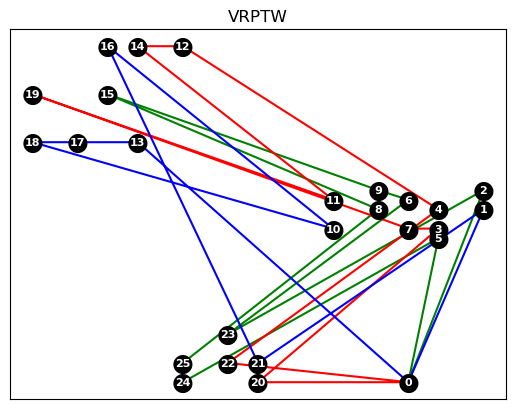

In [18]:
VRP(fichero)

In [23]:
fichero   

,Clientes,X,Y,Demandas,A,B,Servicio
0,0,35,35,0,0,230,0
1,1,41,49,10,161,171,10
2,2,35,17,7,50,60,10
3,3,55,45,13,116,126,10
4,4,55,20,19,149,159,10
5,5,15,30,26,34,44,10
6,6,25,30,3,99,109,10
7,7,20,50,5,81,91,10
8,8,10,43,9,95,105,10
9,9,55,60,16,97,107,10
